# Spatial Proteomics Analysis for CODEX Data

This tutorial provides a comprehensive guide to analyzing spatial proteomics data generated from CODEX (CO-Detection by indEXing) technology. We will cover the following steps:

1. Introduction to CODEX Data
2. Cell Segmentation Using Stardist and QuPath
3. Loading Measurements in Python and Performing Downstream Analysis

### QuPath for Visualization and Analysis
QuPath is an open-source software for bioimage analysis. It provides tools for visualizing and analyzing segmentation results.

Step-by-Step Guide to Using QuPath
Install QuPath:

1. Download and install QuPath from the [official website](https://qupath.github.io/).
2. Install [stardist](https://github.com/qupath/qupath-extension-stardist) for QuPath
3. Follow this [instruction](https://qupath.readthedocs.io/en/0.4/docs/deep/stardist.html) for cell segmentation



In [1]:
#TODO add data

In [10]:
from qimrtraining.utils import (Read_CODEX_QuPath,QC_plot_Protein,
                                preprocess_fluo, higher_z_score)
import pandas as pd
import stlearn as st
import anndata as ad
import numpy as np
from pathlib import Path
from PIL import Image
import seaborn as sns
import scanpy as sc
import monkeybread as mb

### Load QuPath output into anndata format

In [3]:
DATA_PATH = Path().resolve().parent / "DATA"
codex_path = DATA_PATH / "CODEX/CODEX_01A_S05.txt"

In [4]:
library_id, adata = Read_CODEX_QuPath(codex_path, parent="tissue_3", library_id="S05_t3")

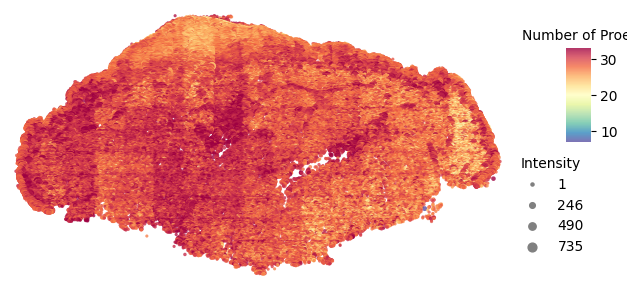

In [5]:
QC_plot_Protein(adata)

### Preprocessing

In [6]:
sc.pp.filter_cells(adata, min_counts=1)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.raw = adata.copy()
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver="arpack", n_comps=20)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(adata)
sc.tl.leiden(adata, flavor="igraph", n_iterations=2, resolution=0.3)
adata.write(DATA_PATH / f"{library_id}_processed.h5ad")

2024-05-29 14:12:22.128223: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-29 14:12:22.131656: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-29 14:12:22.170583: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-29 14:12:22.170611: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-29 14:12:22.170631: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

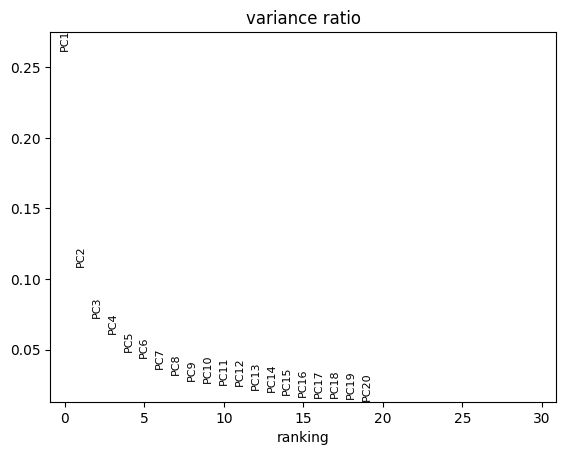

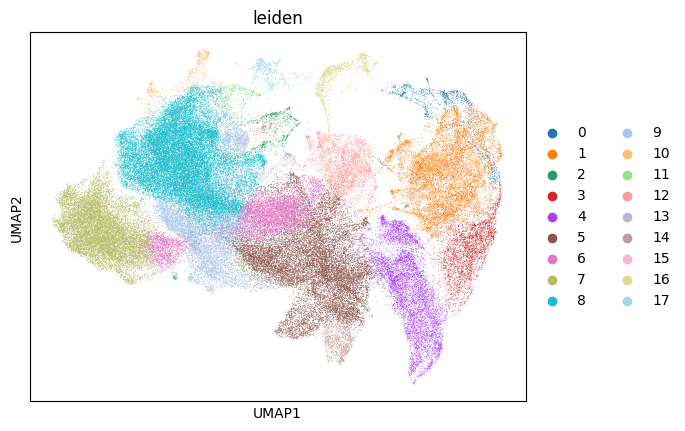

In [7]:
sc.pl.pca_variance_ratio(adata)
sc.pl.umap(adata, color="leiden")

### Marker based on annotation

In [8]:
marker_cell_dict ={'HLA-A': 'MHC I',
 'CD45': 'Leukocytes',
 'CD3e': 'T cells',
 'CD4': 'CTLs',
 'CD8': 'Th cells',
 'FOXP3': 'Treg cells',
 'GranzymeB': 'NKcs',
 'CD19': 'B cells',
 'CD20': 'B cells',
 'CD21': 'B cells',
 'CD11b': 'Inflammation',
 'MPO': 'Neutrophils',
 'CD68': 'Macrophages',
 'CD163': 'M2 macrophages/DCs',
 'CD11c': 'Phagocytes',
 'HLA-DR': 'MHC II',
#  'CD31': 'Blood vessels',
 'CD34': 'Blood vessels',
 'SMA': 'Blood vessels',
 'Podoplanin': 'Lymphatic vessels',
 'Keratin 14': 'Epithelium',
 'Pan-Cytokeratin': 'Epithelium',
 'Ki67': 'Proliferation',
#  'PD1': 'Immune checkpoint',
#  'PD-L1': 'Immune checkpoint',
#  'LAG3': 'Immune checkpoint',
#  'IDO1': 'Immune checkpoint',
 'PMEL': 'Melanoma',
#  'SOX10': 'Melanoma',
 'S100B': 'Melanoma',
#  'S100A4': 'Melanoma',
#  'HIF1A': 'Melanoma',
 'Vimentin': 'Fibroblasts'
 }

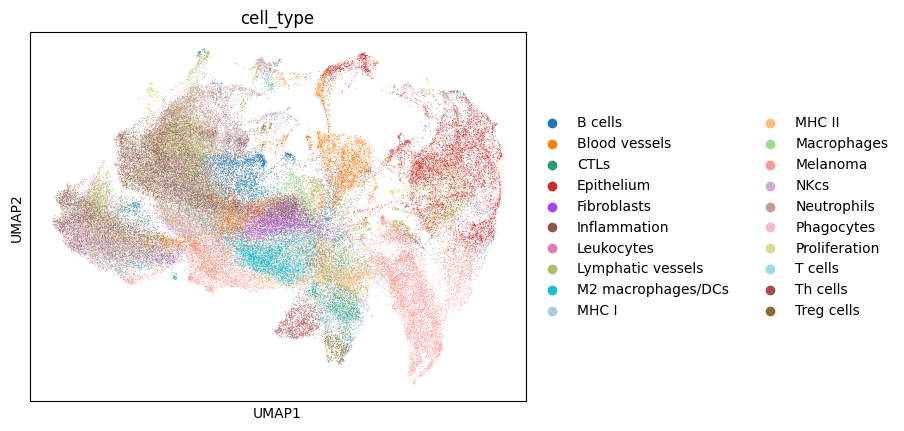

/opt/anaconda3/envs/stimage2/lib/python3.10/site-packages/stlearn/plotting/classes.py:733: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for i, cluster in enumerate(self.query_adata.obs.groupby(self.use_label)):


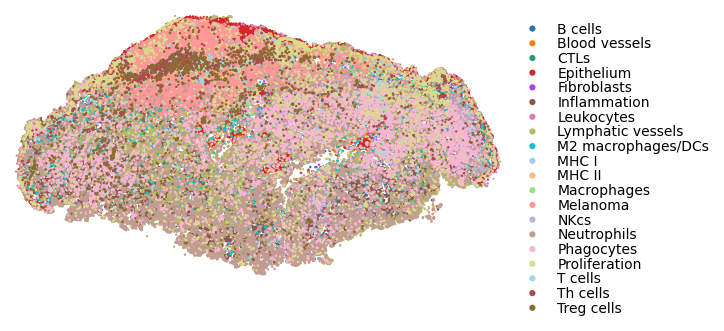

In [9]:
higher_z_score(adata, marker_cell_dict)
sc.pl.umap(adata, color="cell_type")
st.pl.cluster_plot(adata, use_label="cell_type", size=3)

### Niche analysis

In [12]:
niche_subtypes = []
other_cell_types = ['Blood vessels', "others"]
for cell, ct in zip(adata.obs.index, adata.obs['cell_type']):
    if ct in other_cell_types:
        niche_subtypes.append('Blood vessels/others')
    else:
        niche_subtypes.append(ct)
adata.obs['niche_subtypes'] = adata.obs['cell_type']
adata.obs['niche_subtypes'] = adata.obs['niche_subtypes'].astype('category')
adata.obsm["X_spatial"] = adata.obsm["spatial"]
print("Cell subtypes considered in niche analysis:")
print(set(adata.obs['niche_subtypes']))
# Compute niches
mask = ~adata.obs['niche_subtypes'].isin([
    'Blood vessels', "others"
])
adata_neighbors = mb.calc.cellular_niches(
    adata,
    cell_type_key='niche_subtypes',
    radius=75,
    normalize_counts=True,
    standard_scale=True,
    clip_min=-5,
    clip_max=5,
    n_neighbors=100,
    resolution=0.2,
    mask=mask,
    min_niche_size=300,
    key_added='niche',
    non_niche_value='Blood vessels/others'
)


Cell subtypes considered in niche analysis:
{'MHC II', 'Blood vessels', 'Treg cells', 'Th cells', 'Epithelium', 'CTLs', 'NKcs', 'B cells', 'Melanoma', 'M2 macrophages/DCs', 'Fibroblasts', 'Proliferation', 'Neutrophils', 'Leukocytes', 'Macrophages', 'Inflammation', 'Lymphatic vessels', 'Phagocytes', 'T cells', 'MHC I'}
Computing neighborhood profiles...


In [ ]:
for library_id, adata in adata_dict.items():
    print(library_id)
    adata.obs["niche"] = pd.Categorical(adata.obs["niche"])
    st.pl.cluster_plot(adata, use_label="niche", size=3)
    mb.plot.neighbors_profile_matrixplot(
    adata_neighbors,
    'niche',
    include_niches=[
        niche 
        for niche in set(adata_neighbors.obs['niche'])
        if niche != 'Blood vessels'
    ],
    clustermap_kwargs={
        'linewidths': 0.5,
        'linecolor': 'black',
        'cmap': 'bwr',
        'clip_on': False,
        'vmin': -3.5,
        'vmax': 3.5,
        'figsize': (8,8)
    }
    )
    break